### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
import subjects
from tqdm.notebook import tqdm
from neuropy.utils.signal_process import FourierSg, filter_sig

### Is the overall power spectrum changing from early to late sleep deprivation

In [2]:
sessions = subjects.sd.ripple_sess

psd_df = []
for s, sess in enumerate(tqdm(sessions)):
    fs = sess.eegfile.sampling_rate
    # epochs = sess.get_zt_epochs(include_pre=False, include_maze=False)
    post = sess.paradigm["post"].flatten()
    starts = np.array([post[0], post[0] + 4 * 3600])
    zt_epochs = sess.paradigm.from_array(starts, starts + 3600, ["0-1", "4-5"])
    channel = sess.ripple.metadata["channels"][3]

    for e in zt_epochs.itertuples():
        trace = sess.eegfile.get_signal(channel, e.start, e.stop).traces[0]
        f, pxx = sg.welch(trace, fs=fs, nperseg=4 * fs, noverlap=0)
        pxx = pxx * (0.95 * 1e-3) ** 2
        psd_df.append(pd.DataFrame(dict(zt=e.label, f=f, pxx=pxx, grp=sess.tag)))

psd_df = pd.concat(psd_df, ignore_index=True)

  0%|          | 0/8 [00:00<?, ?it/s]

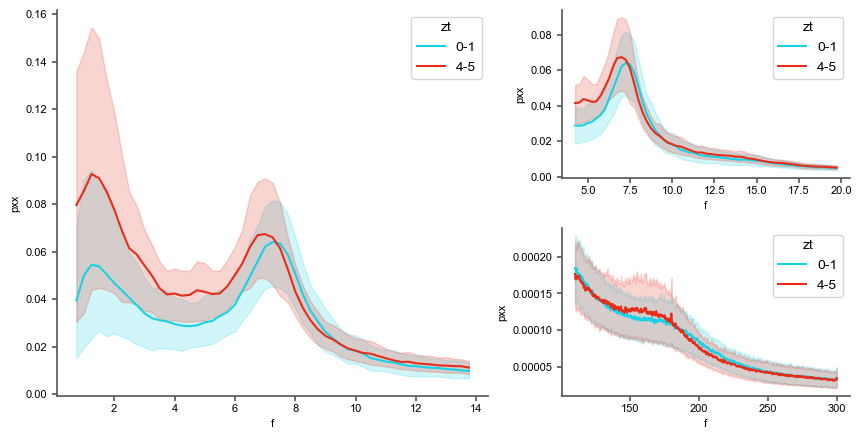

In [6]:
fig = plotting.Fig(6, 5)
freq_bands = [(0.5, 14), (4, 20), (110, 300)]

axes = [fig.gs[:2, :3], fig.gs[0, 3:5], fig.gs[1, 3:5]]
for i, (low, high) in enumerate(freq_bands):
    ax = fig.subplot(axes[i])
    data = psd_df[(psd_df.f > low) & (psd_df.f < high)]
    sns.lineplot(
        data=data,
        x="f",
        y="pxx",
        hue="zt",
        ci=95,
        ax=ax,
        palette=["#1AD2E5", "#E52D1A"],
    )

In [ ]:
fig = plotting.Fig(6, 5)
freq_bands = [(0.5, 350), (4, 20), (110, 300)]

axes = [fig.gs[:2, :3], fig.gs[0, 3:5], fig.gs[1, 3:5]]
for i, (low, high) in enumerate(freq_bands):
    ax = fig.subplot(axes[i])
    data = psd_df[(psd_df.f > low) & (psd_df.f < high)]
    sns.lineplot(
        data=data,
        x="f",
        y="pxx",
        hue="zt",
        ci=None,
        ax=ax,
        palette=["#1AD2E5", "#E52D1A"],
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

# fig.savefig(subjects.figpath_sd / "pxx_sd_zt1_vs_zt5")

### Shot noise in .dat file lfp

In [ ]:
sessions = subjects.nsd.ratSday2

psd_df = []
for s, sess in enumerate(tqdm(sessions)):
    fs = sess.datfile.sampling_rate
    # epochs = sess.get_zt_epochs(include_pre=False, include_maze=False)
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    # starts = np.array([post[0], post[0] + 4 * 3600])
    # zt_epochs = sess.paradigm.from_array(starts, starts + 3600, ["0-1", "4-5"])

    channel = sess.ripple.metadata["channels"][3]

    t1, t2 = maze[0], maze[1]
    trace = sess.datfile.get_signal(channel, t1, t2).traces[0]
    f, pxx_maze = sg.welch(trace, fs=fs, nperseg=4 * fs, noverlap=0)
    pxx_maze = pxx_maze * (0.95 * 1e-3) ** 2

    t1, t2 = post[0] + 3600, post[0] + 3600 + 1800
    trace = sess.datfile.get_signal(channel, t1, t2).traces[0]
    f, pxx_sleep = sg.welch(trace, fs=fs, nperseg=4 * fs, noverlap=0)
    pxx_sleep = pxx_sleep * (0.95 * 1e-3) ** 2

    # psd_df.append(pd.DataFrame(dict(zt=e.label, f=f, pxx=pxx, grp=sess.tag)))


# psd_df = pd.concat(psd_df, ignore_index=True)

In [ ]:
_, ax = plt.subplots()

ax.plot(f, pxx_maze)
ax.plot(f, pxx_sleep)
ax.set_xscale("log")
ax.set_yscale("log")

### Compare broadband slow wave using PCA of z-scored spectrogram
- Also compare it to standard slow wave power

In [ ]:
from sklearn.decomposition import PCA
from numpy.polynomial.polynomial import polyfit

# sess = subjects.nsd.ratNday2[0]
sess = subjects.sd.ratRday2[0]
sw_chan = sess.best_channels.slow_wave
channels = [47, 103]

freqs = np.geomspace(1, 100, 100)
freqs = freqs[(freqs < 57) | (freqs > 63)]

broadband_sw, delta = [], []
for chan in channels:
    signal = sess.eegfile.get_signal(chan)
    spect = FourierSg(signal, freqs=freqs, window=2, overlap=1, norm_sig=True)
    # delta.append(spect.get_band_power(1, 4))
    zsc_spect = stats.zscore(spect.traces, axis=1)
    pca = PCA(n_components=3).fit(zsc_spect.T)
    pca_transform = pca.transform(zsc_spect.T)
    # pca.components_[0][freqs > 25] = 0
    # delta = pca.transform(zsc_spect.T)
    slope = polyfit(freqs, np.log10(spect.traces), deg=1)[1]
    # delta.append(pca_transform[:, 0])
    delta.append(spect.get_band_power(1, 4))
    broadband_sw.append(pca_transform[:, 0])

In [ ]:
_, ax = plt.subplots(2, len(channels), sharex=True, sharey="col")

for i, (x1, x2) in enumerate(zip(delta, broadband_sw)):
    x1 = stats.zscore(x1)
    x2 = stats.zscore(x2)
    y_lim = stats.scoreatpercentile(x1, 99.991)
    ax[0, i].plot(x1)
    ax[0, i].set_ylim(top=y_lim)
    ax[1, i].plot(x2)

# ax.plot(delta[2])
# ax.plot(spect.get_band_power(1, 4) * 100)
# ax.plot(freqs, pca.components_[0])

In [ ]:
_, ax = plt.subplots()

ax.plot(freqs, pca.components_[0])
ax.plot(freqs, pca.components_[1])
ax.plot(freqs, pca.components_[2])
# ax.plot(freqs,pca.components_[4])
ax.set_xscale("log")